### Validate Endpoint

In [1]:
new_request = {}
new_request["messages"] = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "What’s in this image?"},
            {
                "type": "image_url",
                "image_url": {
                    "url": "https://upload.wikimedia.org/wikipedia/commons/thumb/d/dd/Gfp-wisconsin-madison-the-nature-boardwalk.jpg/2560px-Gfp-wisconsin-madison-the-nature-boardwalk.jpg"
                },
            },
        ],
    }
]
new_request["temperature"] = 0.5

In [2]:
from utils import display_messages
display_messages(new_request["messages"])

In [4]:
from gemini_api import convert_openai_to_gemini, send_gemini_request
gemini_request = convert_openai_to_gemini(new_request)
response = send_gemini_request(gemini_request, model="gemini-1.5-flash")
print(response)

2024-10-12 06:14:25.906 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************MGOM


The image shows a wooden boardwalk that leads through a field of tall grass. The sky is blue with white clouds.


### Vision Anomaly Detection

#### View Time Series Data

In [5]:
from prompt import time_series_to_image
from utils import view_base64_image, display_messages
from data.synthetic import SyntheticDataset

data_name = 'trend'
data_dir = f'data/synthetic/{data_name}/eval/'
train_dir = f'data/synthetic/{data_name}/train/'
eval_dataset = SyntheticDataset(data_dir)
eval_dataset.load()
train_dataset = SyntheticDataset(train_dir)
train_dataset.load()

Loaded dataset trend with 400 series.
Loaded dataset trend with 400 series.


In [6]:
from prompt import create_openai_request
from openai_api import send_openai_request
import matplotlib.pyplot as plt

# Set default DPI
plt.rcParams['figure.dpi'] = 240


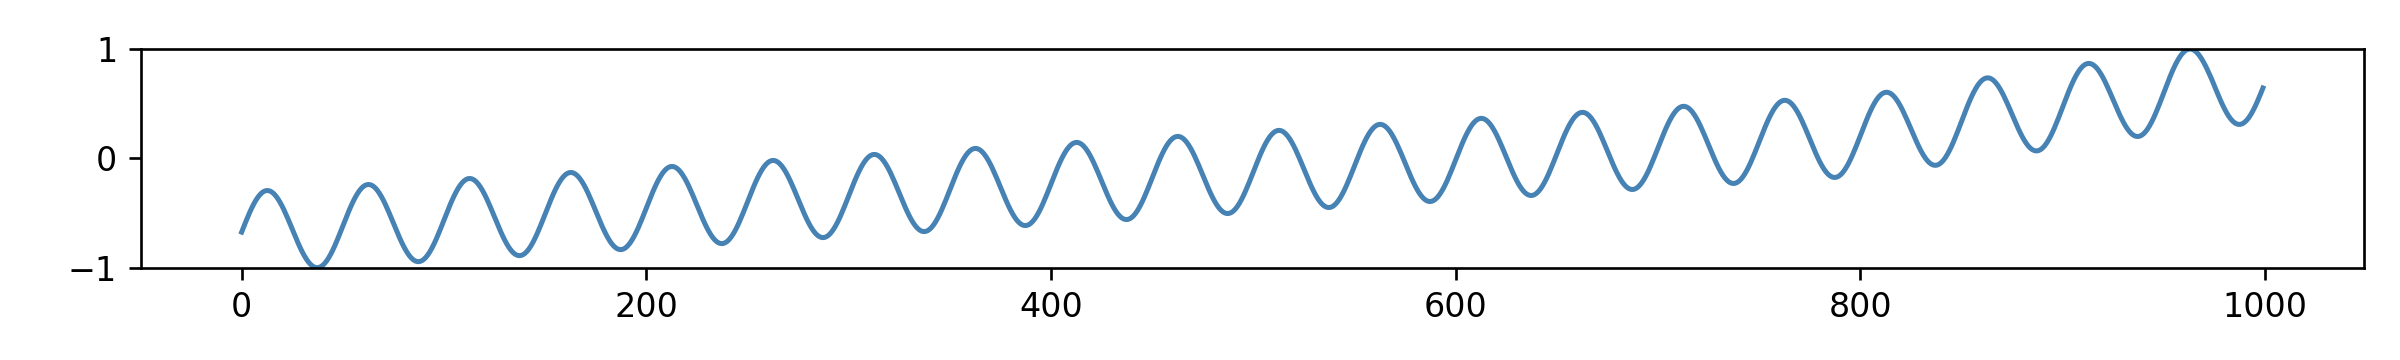
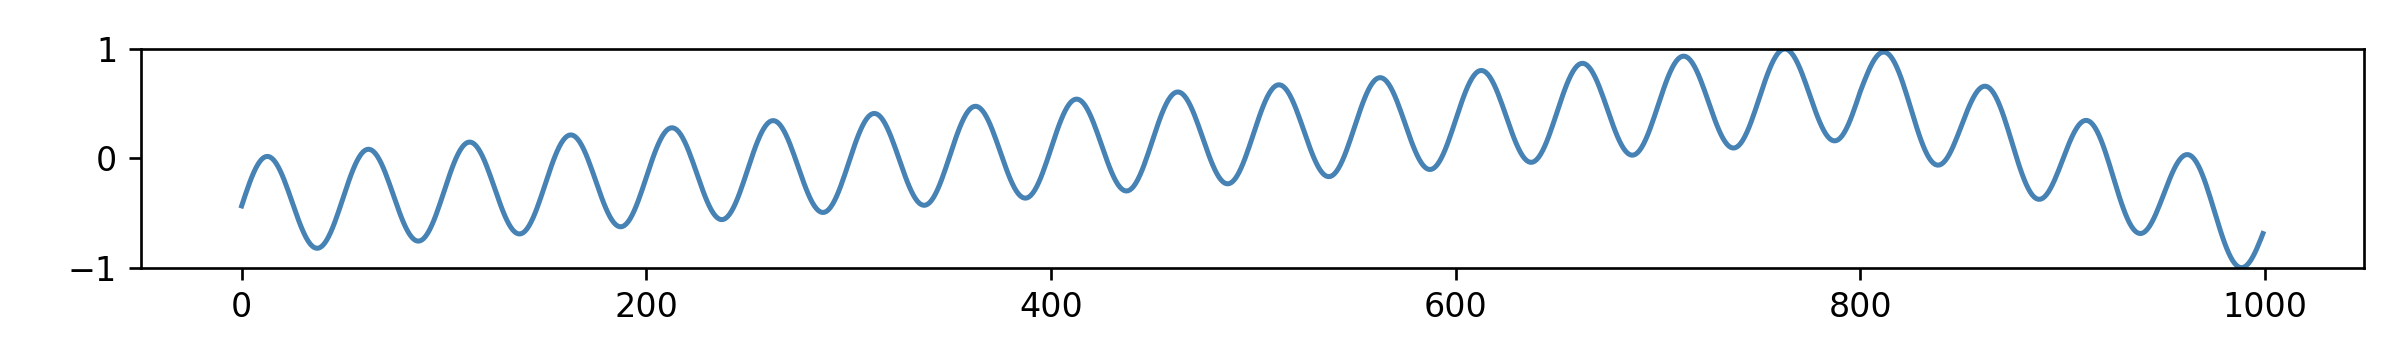

In [23]:
request = create_openai_request(
    eval_dataset[5][1],
    vision=True,
    few_shots=train_dataset.few_shots(num_shots=1)
)
display_messages(request["messages"])

In [24]:
response = send_openai_request(request, model='gemini-1.5-flash')
response

2024-10-12 06:26:05.999 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************MGOM


'[{"start": 875, "end": 975}]\n'

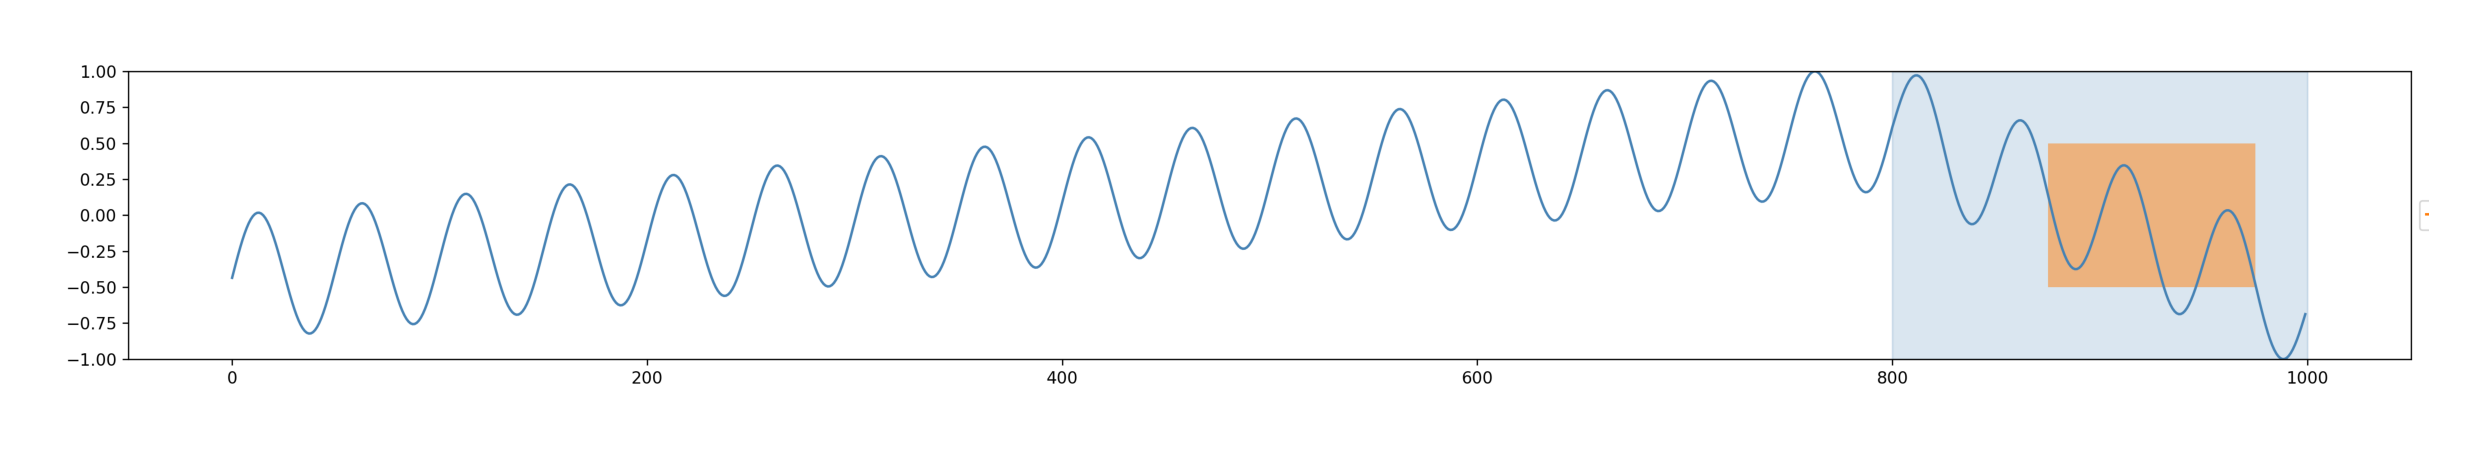

In [29]:
view_base64_image(
    time_series_to_image(
        eval_dataset[5][1], 
        gt_anomaly_intervals=eval_dataset[5][0], 
        anomalies={'gemini-1.5-flash': response},
        fig_size=(20, 3)
    )
)

In [34]:
request = create_openai_request(
    eval_dataset[5][1],
    vision=False,
    few_shots=train_dataset.few_shots(num_shots=0),
    series_args={'scale': 0.3}
)
display_messages(request["messages"])

In [37]:
response = send_openai_request(request, model='gemini-1.5-flash')
response

2024-10-12 06:29:38.504 | DEBUG    | gemini_api:send_gemini_request:93 - API key: ***********************************MGOM


'```json\n[{"start": 19, "end": 49}, {"start": 137, "end": 167}, {"start": 254, "end": 284}]\n```'

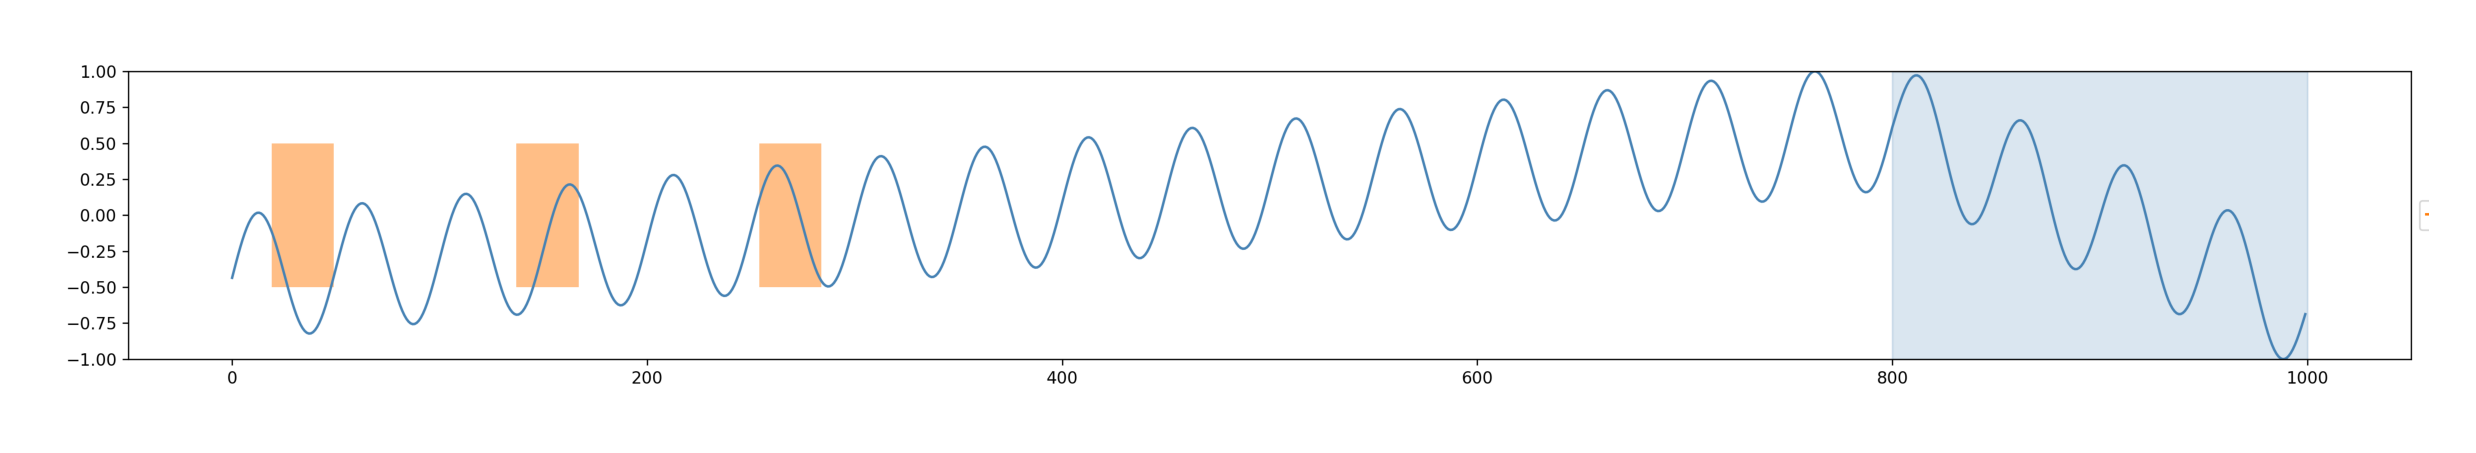

In [38]:
view_base64_image(
    time_series_to_image(
        eval_dataset[5][1], 
        gt_anomaly_intervals=eval_dataset[5][0], 
        anomalies={'gemini-1.5-flash': response},
        fig_size=(20, 3)
    )
)